In [4]:
import networkx as nx, numpy as np, matplotlib.pyplot as plt
G = nx.read_edgelist("../P2/SW-1000-5-0d2-trial3.edges",
                     create_using=nx.Graph(), nodetype=int, comments="%")

Import the data, draw their histogram.

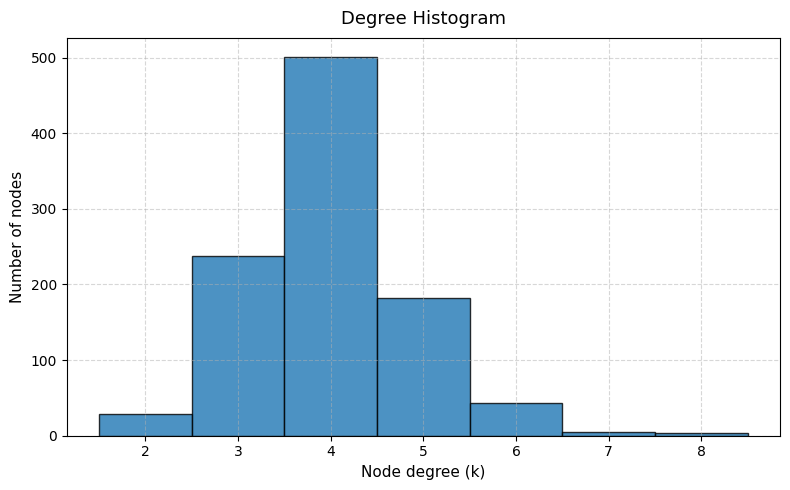

In [5]:
# Compute degree sequence of the network
deg = np.array([d for _, d in G.degree()], dtype=int)

# Define histogram bin edges centered around integer degree values
edges = np.arange(deg.min(), deg.max() + 2) - 0.5

# Count how many nodes have each degree value
counts, edges = np.histogram(deg, bins=edges, density=False)

# Compute the center point of each histogram bin
centers = 0.5 * (edges[1:] + edges[:-1])


def plot_degree_histogram(centers, counts, title="Degree Histogram"):
    plt.figure(figsize=(8, 5))
    plt.bar(centers, counts, width=1.0, color="#1f77b4", alpha=0.8, edgecolor="black")
    plt.grid(True, which="both", linestyle="--", alpha=0.5)

    plt.xlabel("Node degree (k)", fontsize=11)
    plt.ylabel("Number of nodes", fontsize=11)
    plt.title(title, fontsize=13, pad=10)

    plt.tight_layout()
    plt.show()

plot_degree_histogram(centers, counts)


Correct the scale of the plot’s axes to double logarithmic.

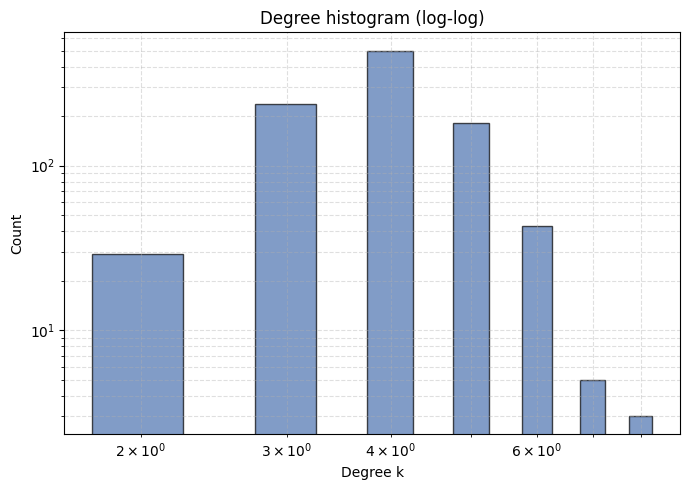

In [6]:
def plot_degree_bar_loglog(centers, counts, title="Degree histogram (log-log)"):

    # delete zeros because log0 not exist
    valid = (centers > 0) & (counts > 0)
    centers = centers[valid]
    counts = counts[valid]

    plt.figure(figsize=(7, 5))

    plt.bar(centers, counts, width=0.5,
            color="#4c72b0", alpha=0.7, edgecolor="black")

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Degree k")
    plt.ylabel("Count")
    plt.title(title)

    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


plot_degree_bar_loglog(centers, counts)


Apply logarithmic binning as well.

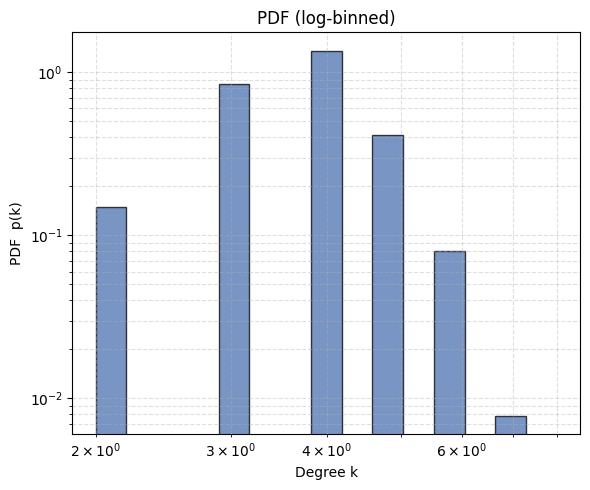

In [8]:
def log_binning_pro(degrees, bins=15):

    degrees = np.array(degrees)
    degrees = degrees[degrees > 0]

    if len(degrees) == 0:
        raise ValueError("No degrees > 0 — cannot perform log-binning.")

    # Compute min/max on log10 scale
    log_min = np.log10(degrees.min())
    log_max = np.log10(degrees.max())

    # Logarithmically spaced bin edges
    edges = np.logspace(log_min, log_max, bins + 1)

    # Histogram counts in each bin (not normalized)
    counts, edges = np.histogram(degrees, bins=edges, density=False)

    # Bin widths (in linear scale)
    widths = np.diff(edges)

    # Compute probability density: p(k)
    density = counts / (counts.sum() * widths)

    # Geometric mean for bin centers in log scale
    centers = np.sqrt(edges[:-1] * edges[1:])

    return centers, density, widths


def plot_degree_pdf_loglog(centers, density, widths, title="PDF (log-binned)"):

    plt.figure(figsize=(6, 5))

    # Use bin widths to draw correct-sized bars
    plt.bar(
        centers,
        density,
        width=widths,
        color="#4c72b0",
        alpha=0.75,
        edgecolor="black"
    )

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Degree k")
    plt.ylabel("PDF  p(k)")
    plt.title(title)

    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


degrees = np.array([d for _, d in G.degree()], dtype=int)
centers, density, widths = log_binning_pro(degrees)

plot_degree_pdf_loglog(centers, density, widths)


Compute and draw the survival function.

The **survival function** \( S(x) \) shows the probability that a value is **greater than or equal to** \( x \):

\[
S(x) = P(X >= x) = 1 - F(x)
\]

where \( F(x) \) is the **cumulative distribution function (CDF)**.
https://www.geeksforgeeks.org/artificial-intelligence/survival-function/


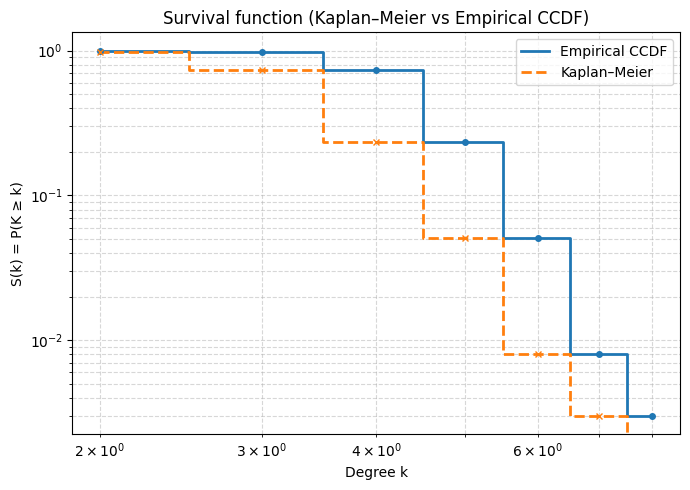

In [10]:
def compute_survival_functions(degrees):
    # Sort all node degrees
    degrees_sorted = np.sort(np.asarray(degrees))

    # Get unique degree values and how many nodes have each degree
    unique_degrees, degree_counts = np.unique(degrees_sorted, return_counts=True)

    # Compute the number of nodes "at risk" (nodes with degree >= current)
    nodes_at_risk = np.cumsum(degree_counts[::-1])[::-1].astype(float)

    # Empirical survival function (CCDF): fraction of nodes with degree >= k
    survival_empirical = nodes_at_risk / nodes_at_risk[0]

    # Kaplan–Meier survival estimate
    survival_km = np.ones_like(degree_counts, dtype=float)
    survival_product = 1.0
    for i, count_i in enumerate(degree_counts):
        n_i = nodes_at_risk[i]
        if n_i > 0:
            # Update survival probability multiplicatively
            survival_product *= (1.0 - float(count_i) / n_i)
        survival_km[i] = survival_product

    return unique_degrees, survival_empirical, survival_km


def plot_survival_comparison(degrees, title="Survival function (Kaplan–Meier vs Empirical CCDF)"):
    unique_degrees, S_emp, S_km = compute_survival_functions(degrees)

    # remove degree = 0 (cannot plot log)
    mask = unique_degrees > 0
    k_vals = unique_degrees[mask]
    S_emp = S_emp[mask]
    S_km = S_km[mask]

    # remove S=0 (log-scale would hide it)
    mask2 = S_emp > 0
    k_vals = k_vals[mask2]
    S_emp = S_emp[mask2]
    S_km = S_km[mask2]

    # reverse order -> correct CCDF direction
    k_vals = k_vals[::-1]
    S_emp = S_emp[::-1]
    S_km = S_km[::-1]

    plt.figure(figsize=(7, 5))
    plt.step(k_vals, S_emp, where="mid", label="Empirical CCDF", lw=2, color="#1f77b4")
    plt.step(k_vals, S_km, where="mid", label="Kaplan–Meier", lw=2, ls="--", color="#ff7f0e")

    plt.plot(k_vals, S_emp, "o", markersize=4, color="#1f77b4")
    plt.plot(k_vals, S_km, "x", markersize=4, color="#ff7f0e")

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Degree k")
    plt.ylabel("S(k) = P(K ≥ k)")
    plt.title(title)

    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return k_vals[::-1], S_emp[::-1], S_km[::-1]


degrees = np.array([d for _, d in G.degree()], dtype=int)
unique_degrees, survival_empirical, survival_km = plot_survival_comparison(degrees)


### Exercise 5

- **Most readable:** The *linear histogram* (Exercise 1) — easy to interpret and visually clear.
- **Most robust to noise:** The *survival function* (Exercise 4) — smooths out fluctuations and handles sparse data better.


Use the linear regression to the previous plots to determine the
parameter α estimator.


### Power-law fit from survival function – theory behind the code

We assume that the degree distribution of the network follows a power law

$$
P(k) \propto k^{-\alpha},
$$

for sufficiently large degrees \(k \ge k_{\min}\).

Instead of working directly with the probability mass function \(P(k)\), we use the
**survival function** (CCDF):

$$
S(k) = P(K \ge k).
$$

For a power-law distribution, the tail also follows a power law:

$$
S(k) \sim k^{-(\alpha - 1)}.
$$

This is because

$$
S(k) = \sum_{k' = k}^{\infty} P(k') \approx
\int_k^{\infty} C x^{-\alpha} \, dx
= \frac{C}{\alpha - 1} k^{-(\alpha - 1)}.
$$

So, up to a constant factor, we have

$$
S(k) \approx C' k^{-(\alpha - 1)}.
$$

---

### Log–log transformation → straight line

Take base-10 logarithms on both sides:

$$
\log_{10} S(k) \approx \log_{10} C' - (\alpha - 1) \log_{10} k.
$$

If we define

$$
X = \log_{10} k, \qquad Y = \log_{10} S(k),
$$

then the above becomes the equation of a straight line:

$$
Y = \underbrace{\log_{10} C'}_{\text{intercept}}
\;+\;
\underbrace{\big(-(\alpha - 1)\big)}_{\text{slope}} X.
$$

So in the linear model

$$
Y = \text{slope} \cdot X + \text{intercept},
$$

we expect

$$
\text{slope} = -(\alpha - 1)
\quad\Longrightarrow\quad
\alpha = 1 - \text{slope}.
$$

This is exactly what we use in the code.

---

### Corresponding Python code (linear regression in log–log space)

```python
# Fit line to log10-log10 transformed data (linear regression in log space)
X = np.log10(k)   # X = log10(k)
Y = np.log10(S)   # Y = log10(S(k))

# Ordinary least squares regression: Y = slope * X + intercept
A = np.vstack([X, np.ones_like(X)]).T
slope, intercept = np.linalg.lstsq(A, Y, rcond=None)[0]

# Power-law exponent α from slope of log–log fit
alpha_est = 1 - slope


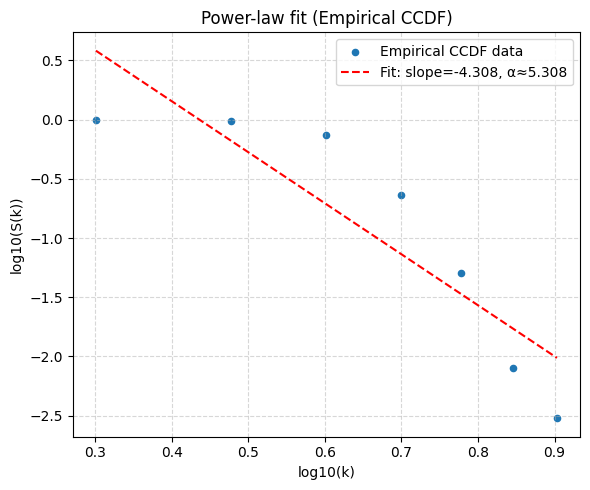

[Empirical CCDF] α ≈ 5.308, slope=-4.308, R²=0.789


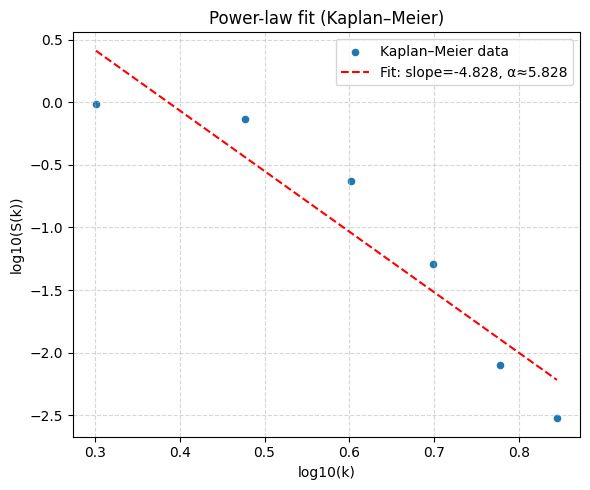

[Kaplan–Meier] α ≈ 5.828, slope=-4.828, R²=0.884


In [11]:
def fit_power_law_from_survival(unique_degrees, survival_values, xmin=2, label="Empirical CCDF"):
    # Select only degrees >= xmin and positive survival values
    mask = (unique_degrees >= xmin) & (survival_values > 0)
    k = unique_degrees[mask]
    S = survival_values[mask]

    if len(k) < 2:
        print(f"[{label}] Not enough data above xmin={xmin}")
        return None

    # Fit line to log10-log10 transformed data (linear regression in log space)
    X = np.log10(k)
    Y = np.log10(S)

    # Ordinary least squares regression: Y = slope * X + intercept
    A = np.vstack([X, np.ones_like(X)]).T
    slope, intercept = np.linalg.lstsq(A, Y, rcond=None)[0]

    # Power-law exponent α from slope of log–log fit
    alpha_est = 1 - slope

    # Compute R2 goodness of fit
    Y_pred = slope * X + intercept
    ss_res = np.sum((Y - Y_pred)**2)
    ss_tot = np.sum((Y - Y.mean())**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    plt.figure(figsize=(6, 5))
    plt.scatter(X, Y, s=20, label=f"{label} data")
    plt.plot(X, Y_pred, "r--", label=f"Fit: slope={slope:.3f}, α≈{alpha_est:.3f}")
    plt.xlabel("log10(k)")
    plt.ylabel("log10(S(k))")
    plt.title(f"Power-law fit ({label})")
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"[{label}] α ≈ {alpha_est:.3f}, slope={slope:.3f}, R²={r2:.3f}")
    return {"alpha": alpha_est, "slope": slope, "intercept": intercept, "r2": r2}


degrees = np.array([d for _, d in G.degree()], dtype=int)

# Compute empirical and Kaplan–Meier survival functions
unique_degrees, survival_empirical, survival_km = compute_survival_functions(degrees)

# Fit power-law model to both survival estimates
res_emp = fit_power_law_from_survival(unique_degrees, survival_empirical, xmin=2, label="Empirical CCDF")
res_km  = fit_power_law_from_survival(unique_degrees, survival_km, xmin=2, label="Kaplan–Meier")


Excercise 7 - uisng Clauset–Shalizi–Newman formula for alfa -MLE

In [51]:
def pareto_alpha_mle(data, xmin):
    x = np.asarray(data, dtype=float)
    x = x[x >= xmin]
    n = x.size
    if n < 1:
        raise ValueError("No observations >= xmin.")
    alpha_hat = 1.0 + n / np.sum(np.log(x / float(xmin)))
    se = (alpha_hat - 1.0) / np.sqrt(n)
    return alpha_hat, se, n

xmin = 2
degrees = np.array([d for _, d in G.degree()], dtype=int)

alpha_hat, se_hat, n_tail = pareto_alpha_mle(degrees, xmin)
print(f"α_MLE ≈ {alpha_hat:.4f}  (SE ≈ {se_hat:.4f}, n_tail = {n_tail})")

α_MLE ≈ 2.5971  (SE ≈ 0.2780, n_tail = 33)


How will the result change if we do not know xmin?


## Power-law parameter estimation when \(x_{\min}\) is unknown
*(Clauset–Shalizi–Newman method)*

### **Step 1 — Select the tail**

Keep only the values in the tail:

$$
x_i \ge x_{\min}
$$

---

### **Step 2 — Estimate \(\alpha\) using the MLE formula**

The maximum likelihood estimator of the power-law exponent is:

$$
\hat{\alpha}
=
1
+
\frac{n}
{\displaystyle \sum_{i=1}^{n} \ln\!\left(\frac{x_i}{x_{\min}}\right)},
$$

where:

- \(n\) is the number of tail samples (those satisfying \(x_i \ge x_{\min}\)).

---

### **Step 3 — Compute the empirical tail CCDF**

$$
S_{\text{emp}}(x)
$$

This is the complementary cumulative distribution function of the data restricted to \(x \ge x_{\min}\).

---

### **Step 4 — Compute the theoretical model survival function**

For a power-law tail with exponent \(\hat{\alpha}\), the theoretical CCDF is:

$$
S_{\text{model}}(x)
=
\left( \frac{x_{\min}}{x} \right)^{\hat{\alpha} - 1}.
$$

---

### **Step 5 — Compute the Kolmogorov–Smirnov (KS) distance**

The KS statistic compares the empirical and model CCDFs:

$$
D
=
\max_{x}
\left|
S_{\text{emp}}(x)
-
S_{\text{model}}(x)
\right|.
$$

---

### **Step 6 — Choose the best \(x_{\min}\)**

Select the value of \(x_{\min}\) that minimizes the KS distance:

$$
x_{\min}^{*}
=
\arg\min_{x_{\min}} D(x_{\min}).
$$

This gives the **best-fitting power-law tail**.


In [52]:
import numpy as np

def alpha_mle_pareto_continuous(x, xmin):
    # Estimate the power-law exponent α (MLE) for data above xmin
    x = np.asarray(x, dtype=float)
    x_tail = x[x > xmin]
    n = x_tail.size
    if n < 1:
        return np.nan, 0
    alpha_hat = 1.0 + n / np.sum(np.log(x_tail / float(xmin)))
    return alpha_hat, n

def empirical_ccdf_tail(x, xmin):
    # Compute the empirical complementary CDF (CCDF) for x ≥ xmin
    x = np.asarray(x, dtype=float)
    x_tail = x[x >= xmin]
    if x_tail.size == 0:
        return np.array([]), np.array([])
    u, c = np.unique(x_tail, return_counts=True)
    surv_counts = c[::-1].cumsum()[::-1].astype(float)
    S_emp = surv_counts / surv_counts[0]
    return u, S_emp

def ks_distance_for_xmin(x, xmin, alpha_hat):
    # Calculate Kolmogorov–Smirnov distance between empirical and model CCDFs
    u, S_emp = empirical_ccdf_tail(x, xmin)
    if u.size == 0:
        return np.inf
    S_model = (xmin / u) ** (alpha_hat - 1.0)
    return np.max(np.abs(S_emp - S_model))

def estimate_alpha_and_xmin(x, xmin_candidates=None, min_tail=20):
    # Scan over possible xmin values to find the one minimizing KS distance
    x = np.asarray(x, dtype=float)
    if xmin_candidates is None:
        xmin_candidates = np.unique(x[x >= 1])
    best = {"xmin": np.nan, "alpha": np.nan, "ks": np.inf, "n_tail": 0}

    for xmin in xmin_candidates:
        alpha_hat, n_tail = alpha_mle_pareto_continuous(x, xmin)
        if n_tail < min_tail or not np.isfinite(alpha_hat):
            continue
        ks = ks_distance_for_xmin(x, xmin, alpha_hat)
        if ks < best["ks"]:
            best.update({"xmin": float(xmin), "alpha": float(alpha_hat), "ks": float(ks), "n_tail": int(n_tail)})
    return best

degrees = np.array([d for _, d in G.degree()], dtype=int)

# Define candidate xmin values and estimate the best-fitting power-law parameters
candidates = np.unique(degrees[degrees >= 2])
result = estimate_alpha_and_xmin(degrees, xmin_candidates=candidates, min_tail=20)

print("Best xmin:", result["xmin"])
print("α (MLE):", result["alpha"])
print("KS distance:", result["ks"])
print("Tail size n:", result["n_tail"])


Best xmin: 2.0
α (MLE): 2.064728062023952
KS distance: 0.09833160930527399
Tail size n: 22


### P4.2 — Proof that for an uncorrelated network
$$
\langle k\rangle_{nn}(k_i) = \frac{\langle k^2\rangle}{\langle k\rangle}
$$

---

**Definitions**

- Degree distribution: \( P(k) \)
- Mean degree:
  $$
  \langle k\rangle = \sum_k k\,P(k)
  $$
- Second moment:
  $$
  \langle k^2\rangle = \sum_k k^2 P(k)
  $$
- Average nearest-neighbor degree for nodes of degree \(k\):
  $$
  \langle k\rangle_{nn}(k) = \sum_{k'} k'\,P(k'|k)
  $$

---

**Key fact (uncorrelated network):**

Degrees at the ends of an edge are **independent**.
The probability that a randomly chosen edge leads to a node of degree \(k'\) is proportional to \(k'P(k')\) —
higher-degree nodes are reached more often:

$$
P(k'|k) = \frac{k'P(k')}{\langle k\rangle} \quad \text{(independent of \(k\))}.
$$

---

**Compute \( \langle k\rangle_{nn}(k) \):**

$$
\begin{aligned}
\langle k\rangle_{nn}(k)
&= \sum_{k'} k' \, P(k'|k) \\
&= \sum_{k'} k' \, \frac{k'P(k')}{\langle k\rangle} \\
&= \frac{1}{\langle k\rangle} \sum_{k'} k'^2 P(k') \\
&= \frac{\langle k^2\rangle}{\langle k\rangle}.
\end{aligned}
$$

---

Since the right-hand side does **not** depend on \(k\),
for any node \(i\) with degree \(k_i\):

$$
\boxed{\langle k\rangle_{nn}(k_i) = \frac{\langle k^2\rangle}{\langle k\rangle}}
$$


Determine the dependence of the average degree of the nearest
neighbor on the degree of the vertex for selected real or artifical
networks.

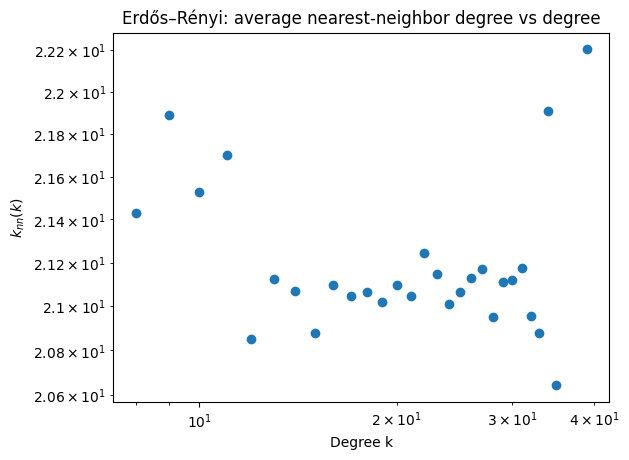

Erdős–Rényi          | assortativity r = +0.004 | log–log slope ≈ -0.006


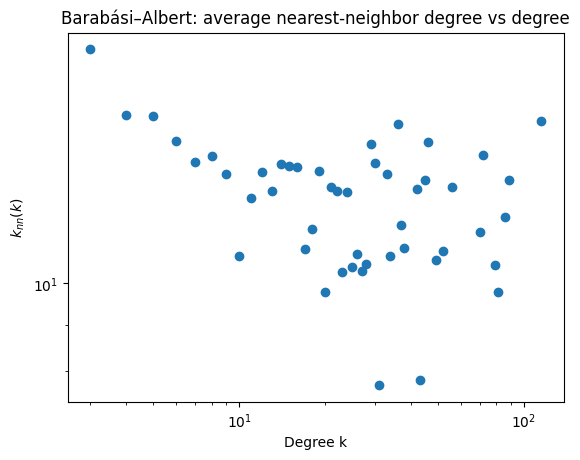

Barabási–Albert      | assortativity r = -0.057 | log–log slope ≈ -0.076


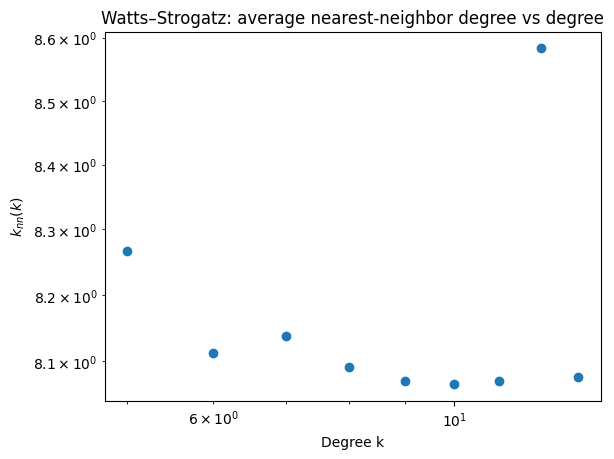

Watts–Strogatz       | assortativity r = -0.021 | log–log slope ≈ +0.005


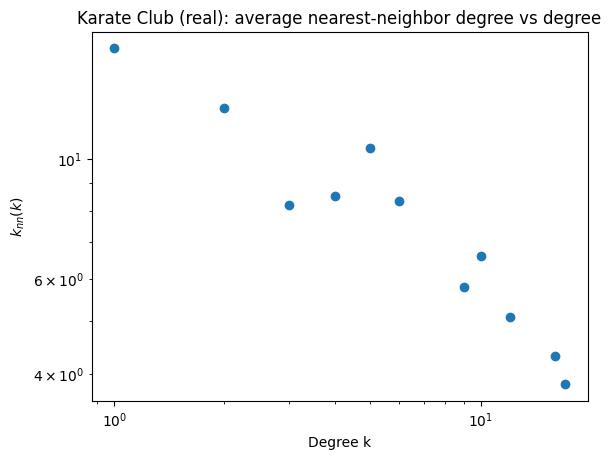

Karate Club (real)   | assortativity r = -0.476 | log–log slope ≈ -0.471


In [14]:
from sklearn.linear_model import LinearRegression
from collections import defaultdict

def knn_by_degree(G):
    # Compute average neighbor degree for each node
    knn_node = nx.average_neighbor_degree(G)
    deg = dict(G.degree())

    # Group nodes by their degree
    bucket = defaultdict(list)
    for v, k in deg.items():
        if k > 0:
            bucket[k].append(knn_node[v])

    # Compute average neighbor degree for each degree value
    k_vals = np.array(sorted(bucket.keys()))
    knn_vals = np.array([np.mean(bucket[k]) for k in k_vals])
    return k_vals, knn_vals

def plot_knn(k_vals, knn_vals, title):
    # Plot average nearest-neighbor degree vs degree on log–log scale
    plt.figure()
    plt.loglog(k_vals, knn_vals, marker='o', linestyle='none')
    plt.xlabel("Degree k")
    plt.ylabel(r"$k_{nn}(k)$")
    plt.title(title)
    plt.show()

def loglog_slope(k_vals, knn_vals, min_points=5):
    # Fit a linear model in log–log space to estimate slope
    mask = (k_vals > 0) & (knn_vals > 0)
    x = np.log10(k_vals[mask]).reshape(-1, 1)
    y = np.log10(knn_vals[mask])
    if x.shape[0] >= min_points:
        lr = LinearRegression().fit(x, y)
        return lr.coef_[0], lr.intercept_
    return np.nan, np.nan

# Generate several synthetic and real networks
n = 2000
p = 0.01
G_er = nx.erdos_renyi_graph(n, p, seed=1)
m = 3
G_ba = nx.barabasi_albert_graph(n, m, seed=1)
k_ws, p_ws = 8, 0.1
G_ws = nx.watts_strogatz_graph(n, k_ws, p_ws, seed=1)
G_karate = nx.karate_club_graph()

for name, G in [
    ("Erdős–Rényi", G_er),
    ("Barabási–Albert", G_ba),
    ("Watts–Strogatz", G_ws),
    ("Karate Club (real)", G_karate),
]:
    k, knn = knn_by_degree(G)  # Compute k_nn(k)
    plot_knn(k, knn, f"{name}: average nearest-neighbor degree vs degree")
    assort = nx.degree_pearson_correlation_coefficient(G)  # Compute assortativity
    slope, _ = loglog_slope(k, knn)  # Compute slope in log–log space
    print(f"{name:20s} | assortativity r = {assort:+.3f} | log–log slope ≈ {slope:+.3f}")


Check how random edge switching affects the result of the
previous task.


=== Erdős–Rényi ===
Assortativity r (original): +0.004
Assortativity r (rewired x5): -0.008


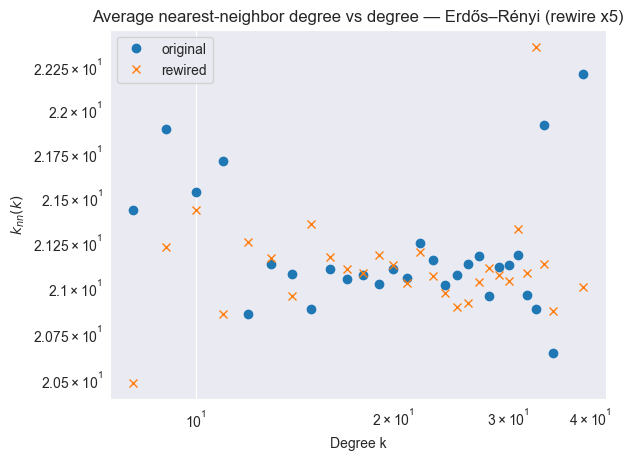

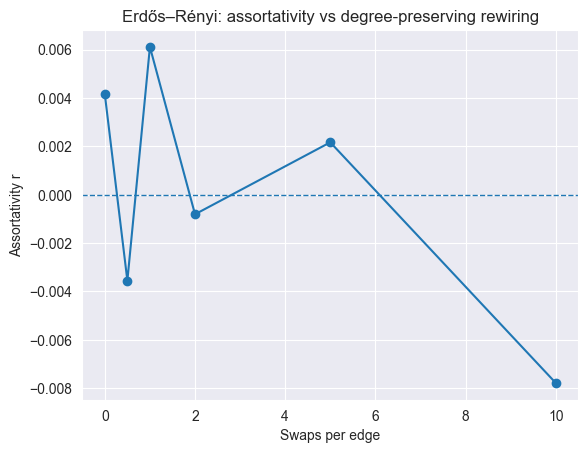


=== Barabási–Albert ===
Assortativity r (original): -0.057
Assortativity r (rewired x5): -0.038


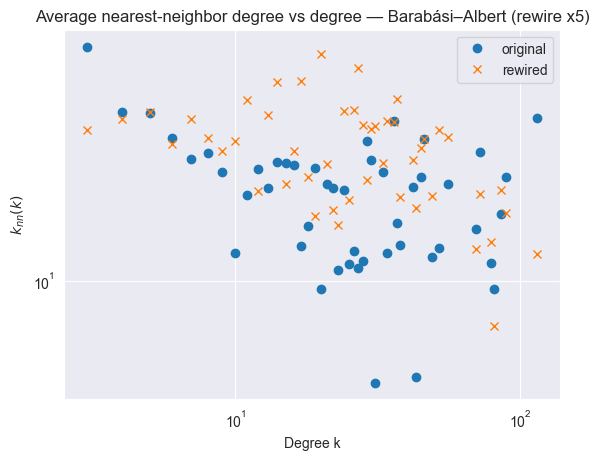

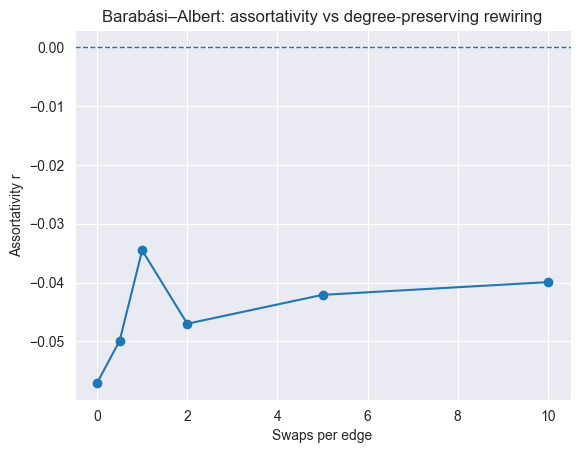


=== Karate Club ===
Assortativity r (original): -0.476
Assortativity r (rewired x5): -0.350


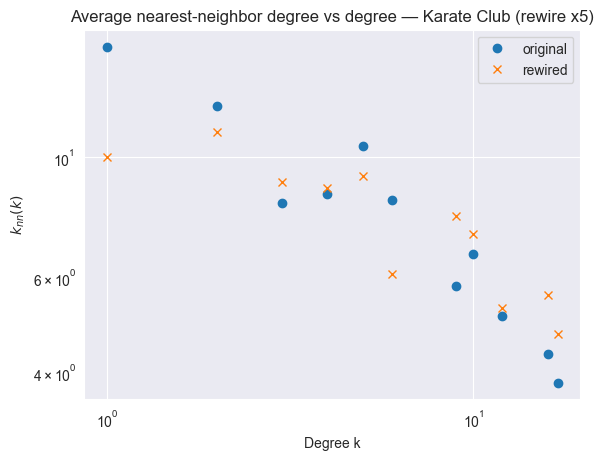

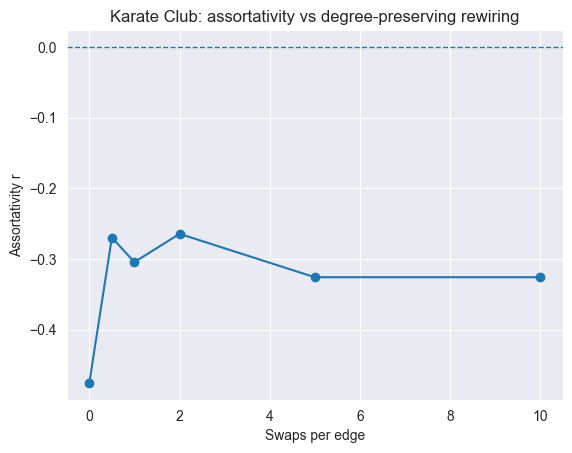

In [40]:
from collections import defaultdict

def knn_by_degree(G):
    # Compute the average neighbor degree for each node and group by node degree
    knn_node = nx.average_neighbor_degree(G)
    deg = dict(G.degree())
    buckets = defaultdict(list)
    for v, k in deg.items():
        if k > 0:
            buckets[k].append(knn_node[v])
    # Compute mean neighbor degree for each unique degree value
    k_vals = np.array(sorted(buckets.keys()))
    knn_vals = np.array([np.mean(buckets[k]) for k in k_vals])
    return k_vals, knn_vals

def degree_preserving_rewire(G, swaps_per_edge=1.0, connected=False, seed=1):
    # Rewire the network randomly while keeping node degrees unchanged
    H = G.copy()
    m = H.number_of_edges()
    nswap = int(max(1, swaps_per_edge * m))
    rng = np.random.default_rng(seed)
    # Perform connected or standard double-edge swaps
    if connected and nx.is_connected(H):
        nx.connected_double_edge_swap(H, nswap=nswap, max_tries=nswap*10, seed=int(rng.integers(0, 1e9)))
    else:
        nx.double_edge_swap(H, nswap=nswap, max_tries=nswap*10, seed=int(rng.integers(0, 1e9)))
    return H

def plot_knn_curves(G_orig, G_rewired, title_suffix=""):
    k0, knn0 = knn_by_degree(G_orig)
    k1, knn1 = knn_by_degree(G_rewired)
    plt.figure()
    plt.loglog(k0, knn0, marker='o', linestyle='none', label='original')
    plt.loglog(k1, knn1, marker='x', linestyle='none', label='rewired')
    plt.xlabel("Degree k")
    plt.ylabel(r"$k_{nn}(k)$")
    plt.title(f"Average nearest-neighbor degree vs degree {title_suffix}")
    plt.legend()
    plt.show()

def sweep_rewiring_and_track(G, sweeps=(0, 0.5, 1, 2, 5, 10), connected=False):
    # Track how assortativity changes as more random swaps are applied
    results = []
    for swe in sweeps:
        H = G if swe == 0 else degree_preserving_rewire(G, swe, connected=connected, seed=42)
        r = nx.degree_pearson_correlation_coefficient(H)
        results.append((swe, r))
    return np.array(results)

n = 2000
G_er = nx.erdos_renyi_graph(n, p=0.01, seed=1)
G_ba = nx.barabasi_albert_graph(n, m=3, seed=1)
G_karate = nx.karate_club_graph()

# Analyze each network before and after degree-preserving rewiring
for name, G in [("Erdős–Rényi", G_er), ("Barabási–Albert", G_ba), ("Karate Club", G_karate)]:
    print(f"\n=== {name} ===")
    r0 = nx.degree_pearson_correlation_coefficient(G)  # original assortativity
    print(f"Assortativity r (original): {r0:+.3f}")
    Grew = degree_preserving_rewire(G, swaps_per_edge=5, connected=False, seed=1)
    r1 = nx.degree_pearson_correlation_coefficient(Grew)  # rewired assortativity
    print(f"Assortativity r (rewired x5): {r1:+.3f}")
    plot_knn_curves(G, Grew, title_suffix=f"— {name} (rewire x5)")

    # Sweep across different levels of rewiring and track assortativity evolution
    sweeps = (0, 0.5, 1, 2, 5, 10)
    arr = sweep_rewiring_and_track(G, sweeps=sweeps, connected=False)
    plt.figure()
    plt.plot(arr[:,0], arr[:,1], marker='o')
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.xlabel("Swaps per edge")
    plt.ylabel("Assortativity r")
    plt.title(f"{name}: assortativity vs degree-preserving rewiring")
    plt.show()


## Summary of Results for \(k_{nn}(k)\) and Assortativity

### Erdős–Rényi (ER)
- Assortativity: \(r \approx 0\) both before and after rewiring.
- The curve \(k_{nn}(k)\) is almost perfectly flat.
- **Conclusion:** ER networks are uncorrelated by definition; degree-preserving rewiring does not change anything.

### Barabási–Albert (BA)
- Assortativity: slightly negative (\(r \approx -0.057\)), becomes closer to 0 after rewiring.
- \(k_{nn}(k)\) decreases with \(k\): hubs connect mostly to low-degree nodes.
- **Conclusion:** BA networks are weakly disassortative; rewiring removes this structural bias.

### Karate Club (real network)
- Assortativity strongly negative (\(r \approx -0.48\)).
- \(k_{nn}(k)\) clearly decreases with \(k\) — strong disassortativity.
- After rewiring: disassortativity decreases but does not fully disappear.
- **Conclusion:** Real social networks often show structural disassortativity; random rewiring weakens but does not remove the pattern fully.

Find the correlation coefficient for the network from task
P4.3-P4..4 (before and after edge switching)

In [42]:
import networkx as nx

def rewire_graph(G, swaps_per_edge=5, seed=42, connected=False):
    H = G.copy()
    m = H.number_of_edges()
    nswap = int(swaps_per_edge * m)

    # Perform degree-preserving rewiring; optionally maintain connectivity
    if connected and nx.is_connected(H):
        nx.connected_double_edge_swap(H, nswap=nswap, seed=seed)
    else:
        nx.double_edge_swap(H, nswap=nswap, max_tries=10 * nswap, seed=seed)
    return H

def r_before_after(G, swaps_per_edge=5, trials=5, connected=False, base_seed=42):
    # Compute assortativity before rewiring
    r_before = nx.degree_pearson_correlation_coefficient(G)
    rs = []

    # Perform several rewiring trials to get stable average results
    for t in range(trials):
        Grew = rewire_graph(G, swaps_per_edge=swaps_per_edge, seed=base_seed + t, connected=connected)
        rs.append(nx.degree_pearson_correlation_coefficient(Grew))

    # Calculate mean and standard deviation of assortativity after rewiring
    r_after_mean = float(np.mean(rs))
    r_after_std = float(np.std(rs))
    return r_before, r_after_mean, r_after_std

n = 2000
G_er = nx.erdos_renyi_graph(n, p=0.01, seed=1)
G_ba = nx.barabasi_albert_graph(n, m=3, seed=1)
G_ws = nx.watts_strogatz_graph(n, k=8, p=0.1, seed=1)
G_karate = nx.karate_club_graph()

for name, G, keep_conn in [
    ("Erdős–Rényi", G_er, False),
    ("Barabási–Albert", G_ba, False),
    ("Watts–Strogatz", G_ws, False),
    ("Karate Club", G_karate, True),
]:
    r0, r1_mean, r1_std = r_before_after(G, swaps_per_edge=5, trials=7, connected=keep_conn, base_seed=100)
    print(f"{name:16s} | r before = {r0:+.4f} | r after = {r1_mean:+.4f} ± {r1_std:.4f}")


Erdős–Rényi      | r before = +0.0042 | r after = -0.0030 ± 0.0083
Barabási–Albert  | r before = -0.0570 | r after = -0.0316 ± 0.0128
Watts–Strogatz   | r before = -0.0207 | r after = -0.0045 ± 0.0094
Karate Club      | r before = -0.4756 | r after = -0.3021 ± 0.0372


Let’s fil the above table with metrics od selected real networks,
use the built-in functions for counting the parameters. Compare
the results with the literature.

In [44]:
import numpy as np
import pandas as pd
import networkx as nx

def _as_pos_arr(x):
    x = np.asarray(x, dtype=float).ravel()
    return x[np.isfinite(x) & (x > 0)]

def estimate_alpha_degree_tail(G, min_tail=6):
    # Estimate the tail exponent (α) for the degree distribution
    deg = np.array([d for _, d in G.degree()], float)
    x = _as_pos_arr(deg)

    # Skip if there are too few observations
    if x.size < max(10, min_tail):
        return np.nan, np.nan, np.nan, int(x.size)

    x.sort()
    uniq = np.unique(x)
    best = dict(ks=np.inf, xmin=np.nan, alpha=np.nan, n_tail=0)

    # Iterate over possible xmin values and find the one minimizing KS distance
    for xm in uniq:
        tail = x[x >= xm]
        n = tail.size
        if n < min_tail:
            continue

        # Estimate α using MLE for Pareto distribution
        alpha = 1.0 + n / np.sum(np.log(tail / xm))

        # Compute empirical and model CDFs for KS test
        F_emp = np.arange(1, n + 1) / n
        F_mod = 1.0 - (np.sort(tail) / xm) ** (-(alpha - 1.0))
        ks = np.max(np.abs(F_emp - F_mod))

        if ks < best["ks"]:
            best.update(ks=float(ks), xmin=float(xm), alpha=float(alpha), n_tail=int(n))

    if not np.isfinite(best["ks"]):
        return np.nan, np.nan, np.nan, 0
    return best["alpha"], best["xmin"], best["ks"], best["n_tail"]

def avg_path_length_gcc(G):
    # Compute average path length within the largest connected component
    if G.number_of_nodes() == 0:
        return np.nan
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    GCC = G.subgraph(comps[0]).copy()
    return nx.average_shortest_path_length(GCC)

def metrics_for_graph(name, G):
    # Compute multiple structural metrics for the graph
    N = G.number_of_nodes()
    E = G.number_of_edges()
    k_avg = 2 * E / N if N else np.nan
    r = nx.degree_pearson_correlation_coefficient(G)
    ell = avg_path_length_gcc(G)
    alpha, xmin, ks, n_tail = estimate_alpha_degree_tail(G, min_tail=6)

    return {
        "Network’s name": name,
        "↔?": "undirected",
        "N": N,
        "E": E,
        "⟨k⟩": k_avg,
        "α": alpha,
        "ℓ": ell,
        "r": r,
        "xmin (deg)": xmin,
        "KS": ks,
        "n_tail": n_tail,
    }

G_karate = nx.karate_club_graph()
G_florentine = nx.florentine_families_graph()
G_davis = nx.davis_southern_women_graph()


rows = []
rows.append(metrics_for_graph("Karate Club", G_karate))
rows.append(metrics_for_graph("Florentine Families", G_florentine))
rows.append(metrics_for_graph("Davis Southern Women (bipartite)", G_davis))

df = pd.DataFrame(
    rows,
    columns=["Network’s name","↔?","N","E","⟨k⟩","α","ℓ","r","xmin (deg)","KS","n_tail"]
)

display_df = df.copy()
for col in ["⟨k⟩","α","ℓ","r","xmin (deg)","KS"]:
    display_df[col] = display_df[col].astype(float).round(3)

print(display_df.to_string(index=False))

display_df.to_csv("P4_7_real_networks_metrics.csv", index=False)
print("\nSaved: P4_7_real_networks_metrics.csv")


                  Network’s name         ↔?  N  E   ⟨k⟩     α     ℓ      r  xmin (deg)    KS  n_tail
                     Karate Club undirected 34 78 4.588 2.874 2.408 -0.476         3.0 0.273      22
             Florentine Families undirected 15 20 2.667 2.196 2.486 -0.375         1.0 0.267      15
Davis Southern Women (bipartite) undirected 32 89 5.562 2.708 2.306 -0.337         3.0 0.181      29

Saved: P4_7_real_networks_metrics.csv
